In [1]:
import xarray as xr
xr.__version__

'0.11.0'

## Set up Dask Cluster

In [2]:
from dask.distributed import Client
from dask_kubernetes import KubeCluster
cluster = KubeCluster(n_workers=8)
client = Client(cluster)
cluster

## Construct Xarray Dataset by Crawling THREDDS Server

The catalog lives here:
https://35.188.100.90.xip.io/thredds/catalog/esgcet/catalog.html

This doesn't work because of an SSL error. Siphon isn't happy about the certificate.

In [3]:
from siphon.catalog import TDSCatalog
cat_url = 'https://35.188.100.90.xip.io/thredds/catalog/esgcet/catalog.html'
cat = TDSCatalog(cat_url)

SSLError: HTTPSConnectionPool(host='35.188.100.90.xip.io', port=443): Max retries exceeded with url: /thredds/catalog/esgcet/catalog.html (Caused by SSLError(SSLError("bad handshake: Error([('SSL routines', 'ssl3_get_server_certificate', 'certificate verify failed')],)",),))

## Manually Build OpenDAP URLs

In [4]:
ranges = ['015101-025012', '025101-035012', '035101-045012',
          '045101-055012', '055101-065012']

base = 'https://35.188.100.90.xip.io/thredds/dodsC/test/pr_Amon_GFDL-CM4_piControl_r1i1p1f1_gr1'
urls = [f'{base}_{time_range}.nc'
        for time_range in ranges]
urls

['https://35.188.100.90.xip.io/thredds/dodsC/test/pr_Amon_GFDL-CM4_piControl_r1i1p1f1_gr1_015101-025012.nc',
 'https://35.188.100.90.xip.io/thredds/dodsC/test/pr_Amon_GFDL-CM4_piControl_r1i1p1f1_gr1_025101-035012.nc',
 'https://35.188.100.90.xip.io/thredds/dodsC/test/pr_Amon_GFDL-CM4_piControl_r1i1p1f1_gr1_035101-045012.nc',
 'https://35.188.100.90.xip.io/thredds/dodsC/test/pr_Amon_GFDL-CM4_piControl_r1i1p1f1_gr1_045101-055012.nc',
 'https://35.188.100.90.xip.io/thredds/dodsC/test/pr_Amon_GFDL-CM4_piControl_r1i1p1f1_gr1_055101-065012.nc']

## Load with Xarray

In [5]:
# convenience function to drop annoying bounds coordinates
def drop_bounds(ds):
    to_drop = [dv for dv in ds.data_vars if 'bnds' in dv]
    return ds.drop(to_drop)
ds = xr.open_mfdataset(urls, preprocess=drop_bounds, chunks={'time': 12})
ds

/srv/conda/lib/python3.6/site-packages/xarray/coding/times.py:122: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy cftime.datetime objects instead, reason: dates out of range
  result = decode_cf_datetime(example_value, units, calendar)


<xarray.Dataset>
Dimensions:  (bnds: 2, lat: 180, lon: 288, time: 6000)
Coordinates:
  * bnds     (bnds) float64 1.0 2.0
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.625 1.875 3.125 4.375 ... 355.6 356.9 358.1 359.4
  * time     (time) object 0151-01-16 12:00:00 ... 0650-12-16 12:00:00
Data variables:
    pr       (time, lat, lon) float32 dask.array<shape=(6000, 180, 288), chunksize=(12, 180, 288)>
Attributes:
    external_variables:              areacella
    table_id:                        Amon
    history:                         File was processed by fremetar (GFDL ana...
    contact:                         gfdl.climate.model.info@noaa.gov
    comment:                         <null ref>
    tracking_id:                     hdl:21.14100/cdcd7052-c5b4-4e8f-83fc-fe1...
    further_info_url:                https://furtherinfo.es-doc.org/CMIP6.NOA...
    branch_time_in_child:            0.0
    branch_method:            

## Try to Compute

This works!

In [6]:
pr_mean = ds.pr.mean(dim='time').load()

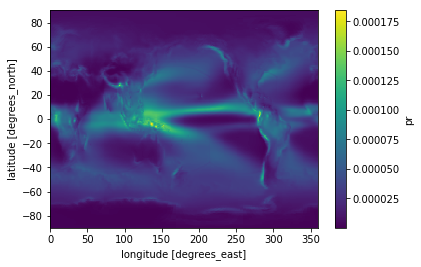

In [7]:
%matplotlib inline
pr_mean.plot()